In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import json


In [2]:
#raw data from
#https://www.leefilters.com/scripts/data/chart-pdf-data.js
rawdata = json.load(open('filters2.json','rb'))

data = {}
for d in rawdata:
    if 'data' in rawdata[d]:
        if len(rawdata[d]['data'])==61:
            data[d] = rawdata[d]['data']
            
lam = np.arange(400,700.1,5) #400-700 steps of 5

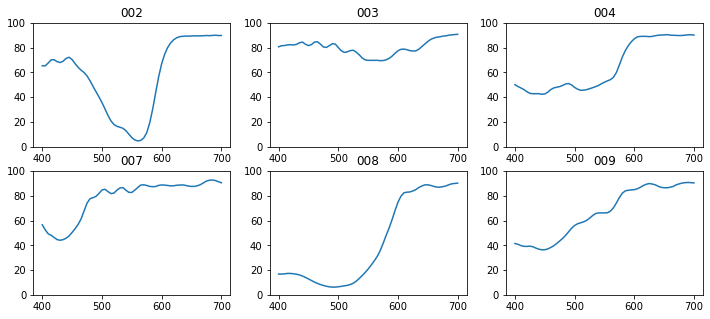

In [3]:
#plt.figure(figsize=[50,120])
plt.figure(figsize=[12,5])
for i,d in enumerate(data):
    #plt.subplot(35,10,i+1)
    if i+1>6: break
    plt.subplot(2,3,i+1)
    
    plt.plot(lam,data[d])
    plt.ylim([0,100])
    plt.title(d)

In [4]:
sensors = []
for col in ['blue','green','red']: 
    df = pd.read_csv('%s.csv' % col,names=['wavelength','percent']) #in nm
    #plt.plot(df['wavelength'],df['percent'],label=col,c=col)
    spec = np.interp(lam, df['wavelength'], df['percent'])
    spec = spec / np.sum(spec) #normalised.
    sensors.append(spec)
#plt.legend()

In [5]:
initialspectrum = np.ones(len(lam))
expected = {}
for filterid in data:
    spectrum = initialspectrum.copy()
    spectrum = spectrum * (np.array(data[filterid])/100) 
    spectrum = spectrum * (np.array(data[filterid])/100) #passes through twice
    resp = []
    for sens in sensors:
        resp.append(np.sum(sens * spectrum))
    if filterid.isdecimal():
        expected[filterid] = resp
    #print(np.mean(resp))

In [6]:
exps = []
for ex in expected:
    exps.append(np.array(expected[ex]))
exps = np.array(exps)

signal = np.mean(exps,1)

sigkeep = signal > 0.2
exps = exps/np.sum(exps,1)[:,None]

allexps = exps.copy()
exps = exps[sigkeep]


In [7]:
dist = np.zeros([len(exps),len(exps)])
for i in range(3):
    dist+=(exps[:,i:(i+1)].T-exps[:,i:(i+1)])**2
dist = np.sqrt(dist)
dist_notfilled = dist.copy()
np.fill_diagonal(dist,100)

In [8]:
print("%d colour initially, %d above 20%%" % (len(sigkeep),len(exps)))

271 colour initially, 162 above 25%


In [9]:
K = 40

def fn(a):
    return np.min(a) #a**0.1 #np.sqrt(a) #np.log(1e-4+a) #np.sqrt(a)#-1/np.sqrt(a)

subsamp = list(np.random.choice(len(dist),K,replace=False))
bestsubsamp = subsamp.copy()
bestscore = -np.inf
for it in range(20000):
    if it%2000==0: subsamp = list(np.random.choice(len(dist),K,replace=False)) #random restarts.
    minpair = np.unravel_index((dist[subsamp,:][:,subsamp]+0.02*np.random.randn(K,K)).argmin(), dist[subsamp,:][:,subsamp].shape)
    #if np.sum(fn(dist_notfilled[subsamp[minpair[0]],:]))<np.sum(fn(dist_notfilled[subsamp[minpair[1]],:])):
    if np.sum(fn(dist[subsamp[minpair[0]],:]))<np.sum(fn(dist[subsamp[minpair[1]],:])):
        use = subsamp[minpair[0]]
    else:
        use = subsamp[minpair[1]]
    subsamp.remove(use)
    while True:
        add = np.random.choice(len(dist),1,replace=False)
        if add not in subsamp: 
            if np.sum(fn(dist[add,subsamp]))>np.sum(fn(dist[use,subsamp])):
            #if np.sum(fn(dist_notfilled[add,subsamp]))>np.sum(fn(dist_notfilled[use,subsamp])):
                break
            if np.random.rand()<0.1: #need to stop eventually.
                break
    subsamp.append(add[0])    
    score = np.nansum(fn(dist[subsamp,:][:,subsamp]))
    if score>bestscore:
        bestscore = score
        bestsubsamp = subsamp.copy()
    if it%1000==0: print(score,bestscore)
        
subsamp = bestsubsamp

0.008923148341733536 0.008923148341733536
0.04200459608958749 0.056211198673994385
0.011397117135035308 0.059502680640916086
0.04674767112826673 0.0598915222699645
0.011051855399405659 0.06007744866078272
0.03171180792849973 0.06148570694878844
0.0022313509567008978 0.06148570694878844
0.024580171764699302 0.06148570694878844
0.001616271563474386 0.06148570694878844
0.025661773118034976 0.06148570694878844
0.010229957391114645 0.06148570694878844
0.03409026256536227 0.06148570694878844
0.01307146159706738 0.06148570694878844
0.030030013739650547 0.06148570694878844
0.004019044460891888 0.06164293421728529
0.040713495412158844 0.06164293421728529
0.009284302543263104 0.06164293421728529
0.03754883675886219 0.06164293421728529
0.004019044460891888 0.06164293421728529
0.03797419618281164 0.06164293421728529


In [10]:
subsamp = bestsubsamp
keep = subsamp

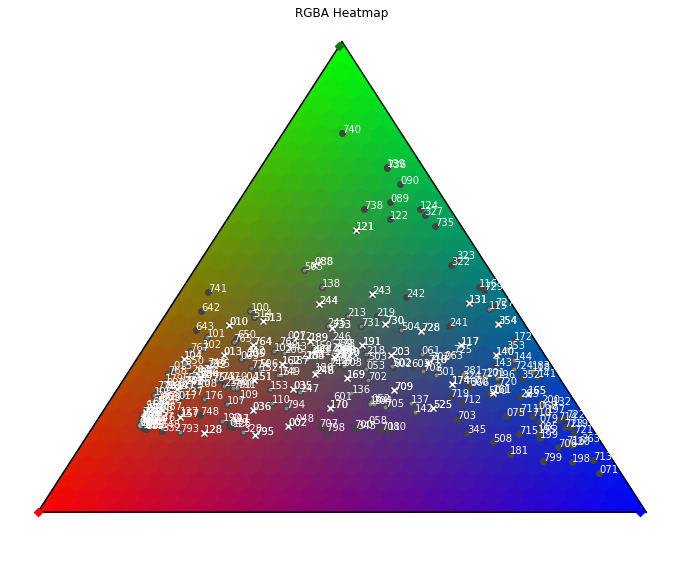

In [60]:
import matplotlib.pyplot as plt
import ternary
import math

def color_point(x, y, z, scale):
    b = x/scale
    g = y/scale
    r = z/scale
    return (r, g, b, 1.)

def generate_heatmap_data(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = color_point(i, j, k, scale)
    return d

#keep = np.mean(exps,1)>0.4
scale = 30
data = generate_heatmap_data(scale)
plt.figure(figsize=[12,10])
ax = plt.gca()
figure, tax = ternary.figure(ax,scale=scale)


tax.scatter(np.array([[0.99,0,0]])*scale,marker='D', color='blue',zorder=3)
tax.scatter(np.array([[0,0.99,0]])*scale,marker='D', color='green',zorder=3)
tax.scatter(np.array([[0,0,0.99]])*scale,marker='D', color='red',zorder=3)

tax.scatter(allexps*scale,marker='o', color='#444f', label="Green Diamonds",zorder=3)#np.array(expected['002']))
tax.scatter(exps*scale,marker='.', color='#aaa8', label="Green Diamonds",zorder=3)#np.array(expected['002']))
tax.scatter(exps[keep,:]*scale,marker='x', color='#fff', label="Green Diamonds",zorder=3)#np.array(expected['002']))
tax._redraw_labels()
tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False)
tax._redraw_labels()
# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.boundary()
tax.set_title("RGBA Heatmap")
#print(len(np.array([e for e in expected])[sigkeep][keep]),len(exps[keep,:]))
for a,b in zip(np.array([e for e in expected])[sigkeep][keep],exps[keep,:]):
    #print(a,b)
    #ax.text((b[0]+b[1])*scale,(b[1])*scale,a,color='white')
    tax.annotate(a,b*scale,color='white')
    #ax.plot(scale*(b[0]+b[1])*np.sqrt(0.5),scale*b[1],'w+')
    
for a,b in zip(np.array([e for e in expected]),allexps):
    tax.annotate(a,b*scale,color='white')
plt.show()


In [59]:
", ".join(sorted(list(np.array([e for e in expected])[sigkeep][keep])))

'002, 010, 013, 021, 035, 036, 088, 104, 117, 121, 128, 131, 140, 147, 151, 157, 161, 162, 165, 169, 170, 174, 189, 191, 203, 217, 243, 244, 248, 354, 513, 525, 604, 709, 718, 728, 730, 733, 764, 795'

In [220]:
e = '002'
e.isdecimal() 

True

In [222]:
[e for e in expected if e.isdecimal()]

['002',
 '003',
 '004',
 '007',
 '008',
 '009',
 '010',
 '013',
 '015',
 '017',
 '019',
 '020',
 '021',
 '022',
 '024',
 '025',
 '026',
 '027',
 '029',
 '035',
 '036',
 '046',
 '048',
 '049',
 '052',
 '053',
 '058',
 '061',
 '063',
 '068',
 '071',
 '075',
 '079',
 '085',
 '088',
 '089',
 '090',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '113',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '124',
 '126',
 '127',
 '128',
 '130',
 '131',
 '132',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '140',
 '141',
 '142',
 '143',
 '144',
 '147',
 '148',
 '151',
 '152',
 '153',
 '154',
 '156',
 '157',
 '158',
 '159',
 '161',
 '162',
 '164',
 '165',
 '169',
 '170',
 '172',
 '174',
 '176',
 '179',
 '180',
 '181',
 '182',
 '183',
 '192',
 '194',
 '195',
 '196',
 '197',
 '198',
 '199',
 '200',
 '201',
 '202',
 '203',
 '204',
 '205',
 '206',
 '207',
 '208',
 '212',
 '213',
 '218',
 '219',
 '223',
 '230',
 '232',
 '236',
 '237',


In [221]:
[e.isdecimal() for e in expected]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,